# Browse TD-MPC2 Runs

Interactive notebook for monitoring training progress, analyzing runs, and managing videos.

## Setup

In [1]:
from pathlib import Path
import sys

# Ensure repo root is importable
ROOT = Path('..').resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

# Configuration
LOGS_DIR = ROOT / 'logs'  # ROOT is already tdmpc2/
WANDB_PROJECT = 'wm-planning/mmbench'
WANDB_LIMIT = None  # No limit
CACHE_PATH = ROOT / 'discover' / 'runs_cache.parquet'
TARGET_STEP = 5_000_000

print(f"ROOT: {ROOT}")
print(f"LOGS_DIR: {LOGS_DIR}")
print(f"WANDB_PROJECT: {WANDB_PROJECT}")

ROOT: /home/projects/dharel/nadavt/repos/newt/tdmpc2
LOGS_DIR: /home/projects/dharel/nadavt/repos/newt/tdmpc2/logs
WANDB_PROJECT: wm-planning/mmbench


## Load Runs Data

In [2]:
from discover.cache import RunsCache

cache = RunsCache(
    logs_dir=LOGS_DIR,
    cache_path=CACHE_PATH,
    wandb_project=WANDB_PROJECT,
    wandb_limit=WANDB_LIMIT,
)

# Load data (set refresh=True to force re-fetch from local/wandb)
df_all, latest_ts, used_cache = cache.load(refresh=True)

print(f"Total rows: {len(df_all)}")
print(f"Using cache: {used_cache}")
print(f"Latest timestamp: {latest_ts}")
df_all.head()

Scanning local logs (/home/projects/dharel/nadavt/repos/newt/tdmpc2/logs)...
  701 local runs found        
Fetching runs from wandb (wm-planning/mmbench)...
wandb: Currently logged in as: nadav-timor (wm-planning) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
  Listed 2207 runs in 418.8s
  Fetching run details (parallel)...


Total rows: 2908
Using cache: False
Latest timestamp: 2025-12-17 07:24:59.689650


  Fetched 2207 run details in 40.1s (55/s)


,task,local_run_id,exp_name,status,ckpt_step,steps,updated_at,wandb_run_id,run_dir,ckpt_path,found_in,url,summary
0,ms-pick-can,20251216_004843_expert_ms-pick-can,expert_ms-pick-can,running,0.0,5000000.0,2025-12-16T02:48:43.871188,None,/home/projects/dharel/nadavt/repos/newt/tdmpc2...,None,local,NaN,NaN
1,og-ant-maze,20251216_004844_expert_og-ant-maze,expert_og-ant-maze,running,0.0,5000000.0,2025-12-16T02:48:44.222972,None,/home/projects/dharel/nadavt/repos/newt/tdmpc2...,None,local,NaN,NaN
2,ms-pick-hammer,20251216_004845_expert_ms-pick-hammer,expert_ms-pick-hammer,running,0.0,5000000.0,2025-12-16T02:48:45.409009,None,/home/projects/dharel/nadavt/repos/newt/tdmpc2...,None,local,NaN,NaN
3,atari-jamesbond,20251216_004858_expert_atari-jamesbond,expert_atari-jamesbond,running,0.0,5000000.0,2025-12-16T02:48:58.980682,None,/home/projects/dharel/nadavt/repos/newt/tdmpc2...,None,local,NaN,NaN
4,atari-ms-pacman,20251216_004858_expert_atari-ms-pacman,expert_atari-ms-pacman,running,0.0,5000000.0,2025-12-16T02:48:58.648084,None,/home/projects/dharel/nadavt/repos/newt/tdmpc2...,None,local,NaN,NaN


## Training Progress Overview

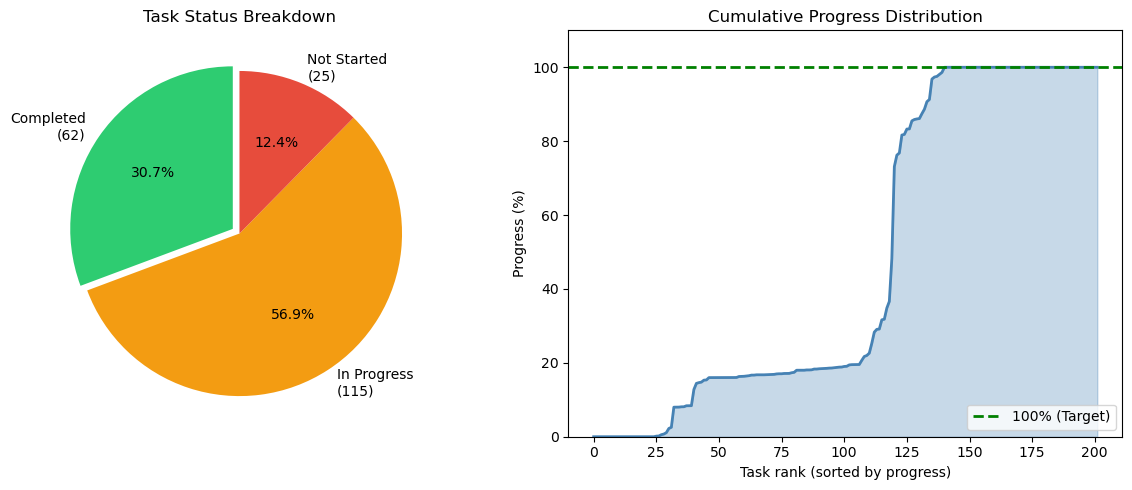

                 TRAINING PROGRESS SUMMARY                  
  Total tasks:            202
  Target step:         5,000,000
------------------------------------------------------------
  ✅ Completed:            62 (30.7%)
  🔄 In Progress:         115 (56.9%)
  ❌ Not Started:          25 (12.4%)
------------------------------------------------------------
  Average progress:      47.3%
  Median progress:       19.0%
  Min steps:                0
  Max steps:           5,000,000


In [3]:
from discover.plots import training_overview

training_overview(df_all, target_step=TARGET_STEP)

## Per-Task Progress

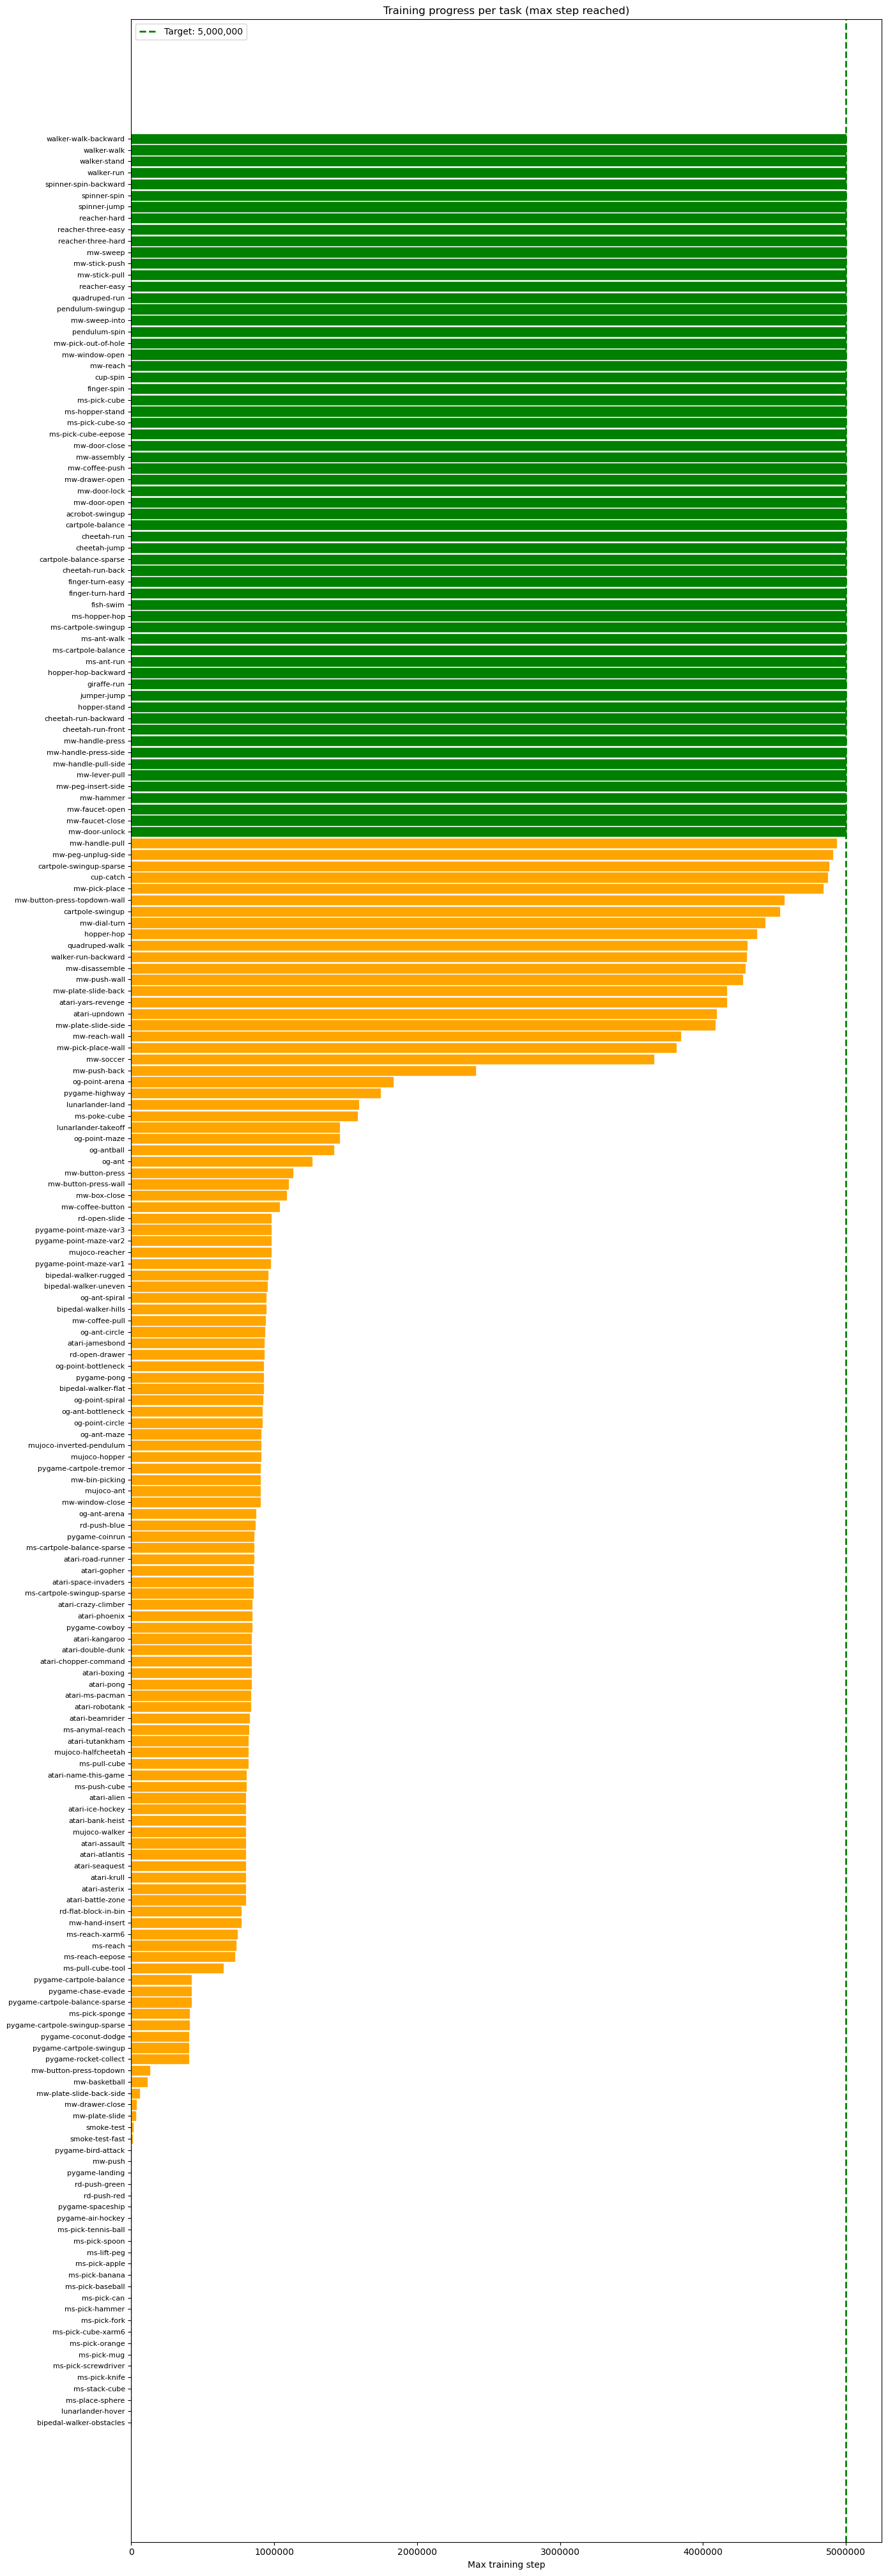

In [4]:
from discover.plots import plot_max_steps

# Green = completed, Orange = in progress, Red = not started
plot_max_steps(df_all, target_step=TARGET_STEP)

## Tasks Requiring Attention

In [5]:
from discover.plots import tasks_needing_attention

tasks_needing_attention(df_all, target_step=TARGET_STEP, bottom_n=15)

                      TASKS REQUIRING ATTENTION                       

❌ NOT STARTED (25 tasks):
----------------------------------------------------------------------
   • bipedal-walker-obstacles
   • lunarlander-hover
   • ms-lift-peg
   • ms-pick-apple
   • ms-pick-banana
   • ms-pick-baseball
   • ms-pick-can
   • ms-pick-cube-xarm6
   • ms-pick-fork
   • ms-pick-hammer
   • ms-pick-knife
   • ms-pick-mug
   • ms-pick-orange
   • ms-pick-screwdriver
   • ms-pick-spoon
   • ms-pick-tennis-ball
   • ms-place-sphere
   • ms-stack-cube
   • mw-push
   • pygame-air-hockey
   • pygame-bird-attack
   • pygame-landing
   • pygame-spaceship
   • rd-push-green
   • rd-push-red

🐢 LAGGING TASKS (bottom 15 by progress):
----------------------------------------------------------------------
   • smoke-test-fast                                      8,000 (0.2%)
   • smoke-test                                          10,000 (0.2%)
   • mw-plate-slide                                      27,600

## Progress by Domain

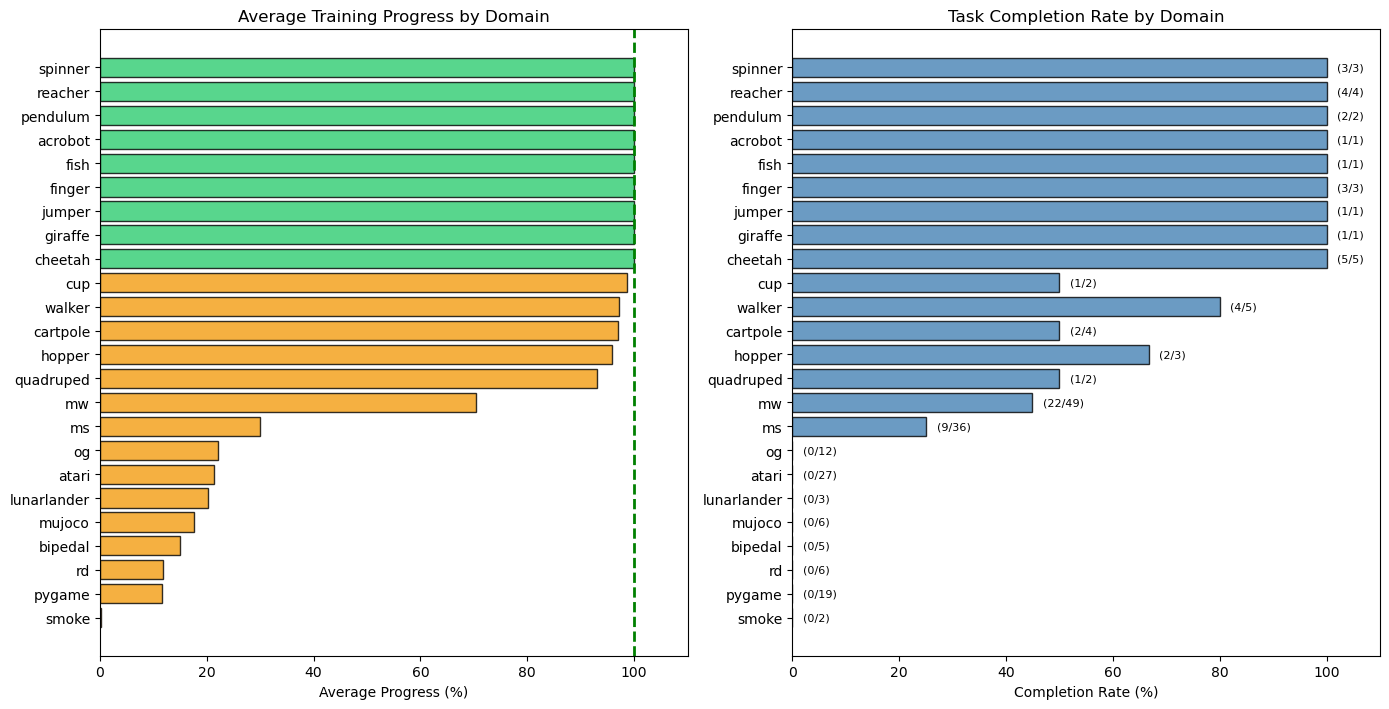


Domain Summary:
--------------------------------------------------------------------------------
Domain                  Tasks   Complete   Avg Progress   Completion %
--------------------------------------------------------------------------------
giraffe                     1          1         100.0%         100.0%
jumper                      1          1         100.0%         100.0%
finger                      3          3         100.0%         100.0%
fish                        1          1         100.0%         100.0%
acrobot                     1          1         100.0%         100.0%
pendulum                    2          2         100.0%         100.0%
reacher                     4          4         100.0%         100.0%
cheetah                     5          5         100.0%         100.0%
spinner                     3          3         100.0%         100.0%
cup                         2          1          98.7%          50.0%
walker                      5          4

In [6]:
from discover.plots import progress_by_domain

progress_by_domain(df_all, target_step=TARGET_STEP)

## Tasks Ready for Evaluation (50%+ trained)

In [7]:
from discover.eval import tasks_ready_for_eval

ready_df, tasks_need_eval, tasks_with_videos = tasks_ready_for_eval(
    df_all,
    logs_dir=LOGS_DIR,
    target_step=TARGET_STEP,
    min_progress=0.5
)

print(f"\nTasks needing eval: {len(tasks_need_eval)}")
print(f"Tasks with videos: {len(tasks_with_videos)}")

                   TASKS READY FOR EVALUATION (≥50% trained)                    

Total tasks at ≥50%: 82
  ✅ With videos:    76
  ❌ Without videos: 6

────────────────────────────────────────────────────────────────────────────────
Tasks WITH videos:
────────────────────────────────────────────────────────────────────────────────
  ✅ acrobot-swingup                                5,000,000 (100.0%)
  ✅ cartpole-balance                               5,000,000 (100.0%)
  ✅ finger-turn-hard                               5,000,000 (100.0%)
  ✅ cartpole-balance-sparse                        5,000,000 (100.0%)
  ✅ cheetah-run                                    5,000,000 (100.0%)
  ✅ cheetah-jump                                   5,000,000 (100.0%)
  ✅ cheetah-run-back                               5,000,000 (100.0%)
  ✅ cup-spin                                       5,000,000 (100.0%)
  ✅ cheetah-run-front                              5,000,000 (100.0%)
  ✅ cheetah-run-backward             

## Generate Eval Script (for tasks without videos)

In [8]:
from discover.eval import generate_eval_script

if tasks_need_eval:
    generate_eval_script(
        tasks=tasks_need_eval,
        output_dir=ROOT / 'jobs',
        project_root=ROOT,
    )
else:
    print("✅ All 50%+ trained tasks already have videos!")

✅ Written task list to: /home/projects/dharel/nadavt/repos/newt/tdmpc2/jobs/tasks_need_eval.txt
   (6 tasks)
✅ Written LSF script to: /home/projects/dharel/nadavt/repos/newt/tdmpc2/jobs/run_eval_need_videos.lsf

📋 To submit the eval jobs, run:
   cd /home/projects/dharel/nadavt/repos/newt/tdmpc2
   bsub < jobs/run_eval_need_videos.lsf


## Collect Videos for Download

In [9]:
from discover.eval import collect_videos

videos_df = collect_videos(
    df_all,
    logs_dir=LOGS_DIR,
    output_dir=ROOT / 'discover' / 'videos_for_presentation',
    target_step=TARGET_STEP,
    min_progress=0.5,
    create_symlinks=True,
)

                       VIDEOS COLLECTED FOR PRESENTATION                        

📁 Output directory: /home/projects/dharel/nadavt/repos/newt/tdmpc2/discover/videos_for_presentation
   Total videos: 76
   Method: symlinks

────────────────────────────────────────────────────────────────────────────────
Task                                                  Step   Progress
────────────────────────────────────────────────────────────────────────────────
  acrobot-swingup                                5,000,000     100.0%
  atari-upndown                                  4,092,000      81.8%
  atari-yars-revenge                             4,164,000      83.3%
  cartpole-balance                               5,000,000     100.0%
  cartpole-balance-sparse                        5,000,000     100.0%
  cartpole-swingup                               4,534,000      90.7%
  cartpole-swingup-sparse                        4,877,000      97.5%
  cheetah-jump                                   5,000,